# Import Libraries

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling #for augmentation
                                     )
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy,  SparseCategoricalAccuracy
from sklearn.metrics import confusion_matrix

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import cv2
from itertools import chain

In [2]:
tf.__version__

'2.10.0'

# Load The Dataset

In [3]:
train_directory = "Human_Emosion_Dataset/train"
validation_directory = "Human_Emosion_Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

In [4]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNAL_SIZE": 3,
    "N_STRIDES": 1,
    "PADDING": "valid",
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [5]:
# Load training dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'int',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99,
)

Found 6719 files belonging to 3 classes.


In [6]:
val_dataset = image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'int',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99,
)

Found 2259 files belonging to 3 classes.


In [7]:
# Print class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['angry', 'happy', 'sad']
Number of classes: 3


# Data Visualizing

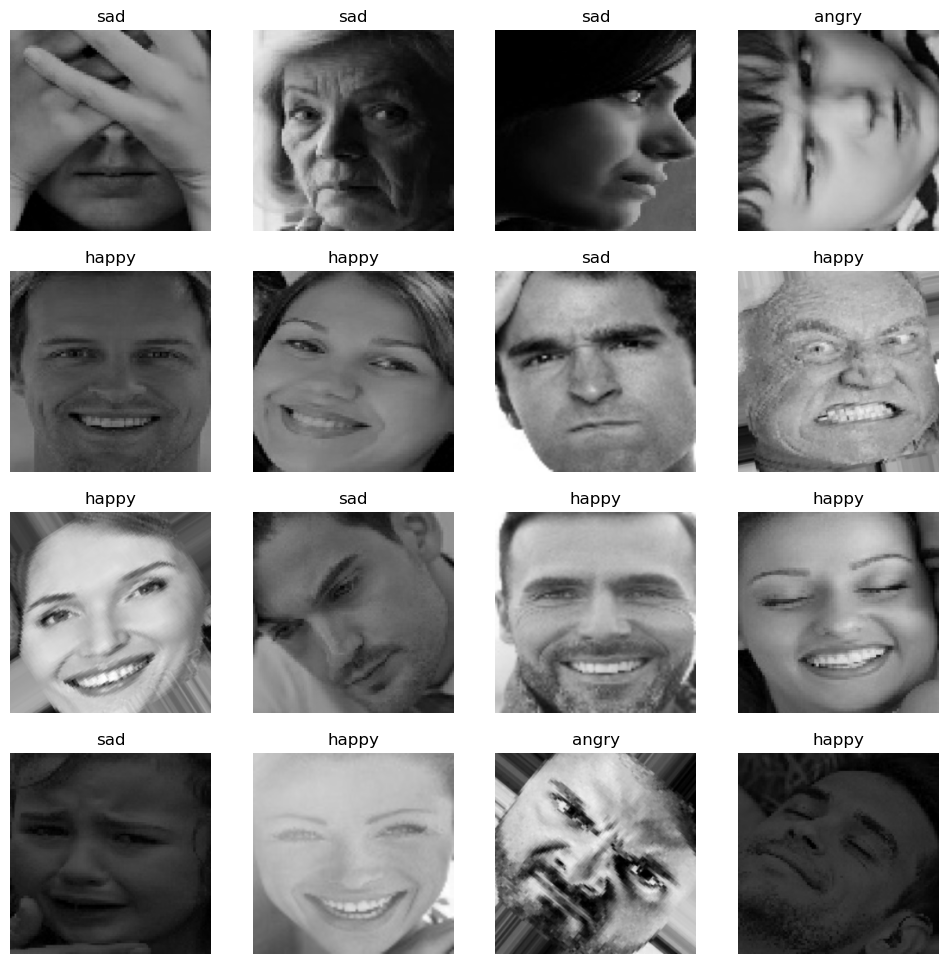

In [8]:
# Create a figure and axes for plotting
plt.figure(figsize=(12, 12))

# Iterate through the first 16 samples in the dataset
for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        # Display the image
        plt.imshow(images[i]/255.)  # Display only the first image in the batch
        # Display the label
        class_name = class_names[labels[i].numpy()]
        plt.title(class_name)

        plt.axis('off')

# Data Preprocessing

## Augmentation

In [9]:
IM_SIZE = CONFIGURATION["IM_SIZE"]

In [10]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode='horizontal', ),
    RandomContrast(factor = 0.1)
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [11]:
resizing_rescaling_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1.0/255)
])

In [12]:
training_dataset = (train_dataset
                 .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
                 #.prefetch(tf.data.AUTOTUNE)
                   )

In [13]:
validation_dataset = (val_dataset
                # .prefetch(tf.data.AUTOTUNE)
                     )

# TFRecords

In [14]:
training_dataset = (
    training_dataset
    .unbatch()
    )

In [15]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [16]:
def create_example(image, label):
    bytes_feature = Feature(
    bytes_list=BytesList(value= [image]))
    int_feature = Feature(
    int64_list = Int64List(value=[label]))


    example = Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,            
        }))
    return example.SerializeToString()

In [17]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [18]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image= tf.io.encode_jpeg(image)
    return image, label

In [19]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

## Write Data

In [20]:
for shard_number in range(NUM_SHARDS):
    sharded_dataset = (
        encoded_dataset
        .shard(num_shards= NUM_SHARDS, index = shard_number)
        .as_numpy_iterator()
    )
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image, label in sharded_dataset:
            file_writer.write(create_example(image, label))

## Read data

In [21]:
l = [PATH.format(p) for p in range(NUM_SHARDS)]
l

['tfrecords/shard_00.tfrecord',
 'tfrecords/shard_01.tfrecord',
 'tfrecords/shard_02.tfrecord',
 'tfrecords/shard_03.tfrecord',
 'tfrecords/shard_04.tfrecord',
 'tfrecords/shard_05.tfrecord',
 'tfrecords/shard_06.tfrecord',
 'tfrecords/shard_07.tfrecord',
 'tfrecords/shard_08.tfrecord',
 'tfrecords/shard_09.tfrecord']

In [22]:
rcons_dataset = tf.data.TFRecordDataset(
    filenames=[PATH.format(p) for p in range(NUM_SHARDS)]
)

In [23]:
def parse_tfrecords(example):
    feature_description = {
        "images": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.io.decode_jpeg(example["images"], channels = 3)
    return example["images"], example["labels"]

In [24]:
parsed_dataset = (rcons_dataset
                 .map(parse_tfrecords)
                  .batch(CONFIGURATION["BATCH_SIZE"])
                 .prefetch(tf.data.AUTOTUNE)
                   )

In [25]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# The Model

In [26]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resizing_rescaling_layers,

    Conv2D(filters=CONFIGURATION["N_FILTERS"],kernel_size=CONFIGURATION["KERNAL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding= CONFIGURATION["PADDING"],
           activation = 'relu', kernel_regularizer = L2(CONFIGURATION["KERNAL_SIZE"])),
    BatchNormalization(),
    MaxPooling2D(pool_size= CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4,kernel_size=CONFIGURATION["KERNAL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding= CONFIGURATION["PADDING"],
           activation = 'relu', kernel_regularizer = L2(CONFIGURATION["KERNAL_SIZE"])),
    BatchNormalization(),
    MaxPooling2D(pool_size= CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(units = CONFIGURATION["N_DENSE_1"], activation= 'relu',
          kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense(units = CONFIGURATION["N_DENSE_2"], activation= 'relu',
          kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax'),
])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

# Loss

In [27]:
loss_fn = SparseCategoricalCrossentropy()

# Optimizers

In [28]:
metrics = [SparseCategoricalAccuracy(name='accuracy')]

In [29]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_fn, 
    metrics= metrics
)

In [30]:
history = lenet_model.fit(parsed_dataset,
                          validation_data=validation_dataset,
                          epochs = CONFIGURATION["N_EPOCHS"], 
                          verbose=1)

Epoch 1/10
210/210 [==============================] - 7s 18ms/step - loss: 11.7230 - accuracy: 0.4178 - val_loss: 56.2684 - val_accuracy: 0.3298
Epoch 2/10
210/210 [==============================] - 3s 14ms/step - loss: 1.1346 - accuracy: 0.7464 - val_loss: 144.1927 - val_accuracy: 0.3298
Epoch 3/10
210/210 [==============================] - 3s 14ms/step - loss: 0.5868 - accuracy: 0.8605 - val_loss: 646.0566 - val_accuracy: 0.3298
Epoch 4/10
210/210 [==============================] - 3s 14ms/step - loss: 0.4533 - accuracy: 0.9021 - val_loss: 635.0648 - val_accuracy: 0.3333
Epoch 5/10
210/210 [==============================] - 3s 14ms/step - loss: 0.3894 - accuracy: 0.9274 - val_loss: 1119.6270 - val_accuracy: 0.3448
Epoch 6/10
210/210 [==============================] - 3s 14ms/step - loss: 0.3229 - accuracy: 0.9424 - val_loss: 1064.1155 - val_accuracy: 0.3289
Epoch 7/10
210/210 [==============================] - 3s 14ms/step - loss: 0.3070 - accuracy: 0.9495 - val_loss: 2994.7324 - val

# Loss

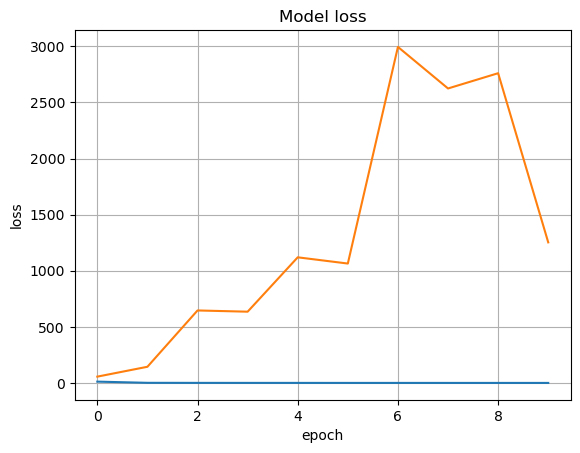

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

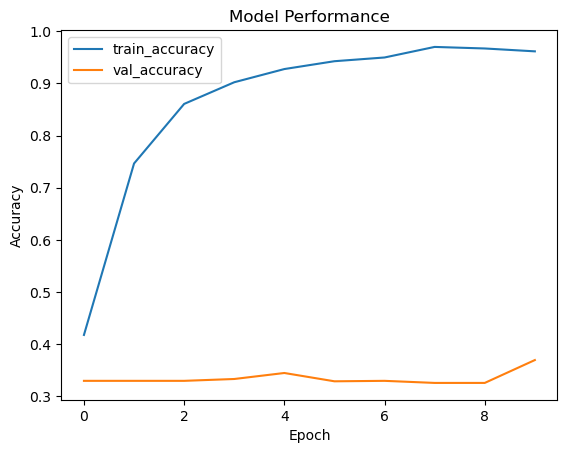

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [33]:
evals = lenet_model.evaluate(validation_dataset, return_dict = True)
evals

71/71 [==============================] - 1s 9ms/step - loss: 1252.8400 - accuracy: 0.3696


{'loss': 1252.8399658203125, 'accuracy': 0.3696325719356537}

# Testing

In [34]:
test_image = cv2.imread("Human_Emosion_Dataset/test/happy/100610.jpg_brightness_1.jpg")
im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis = 0)
result = lenet_model(im)
print(result)

tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)


In [35]:
index = tf.argmax(result, axis = -1).numpy()[0]
print(index)

0


In [36]:
print(CLASS_NAMES[index])

angry


# Visualize Validation Data

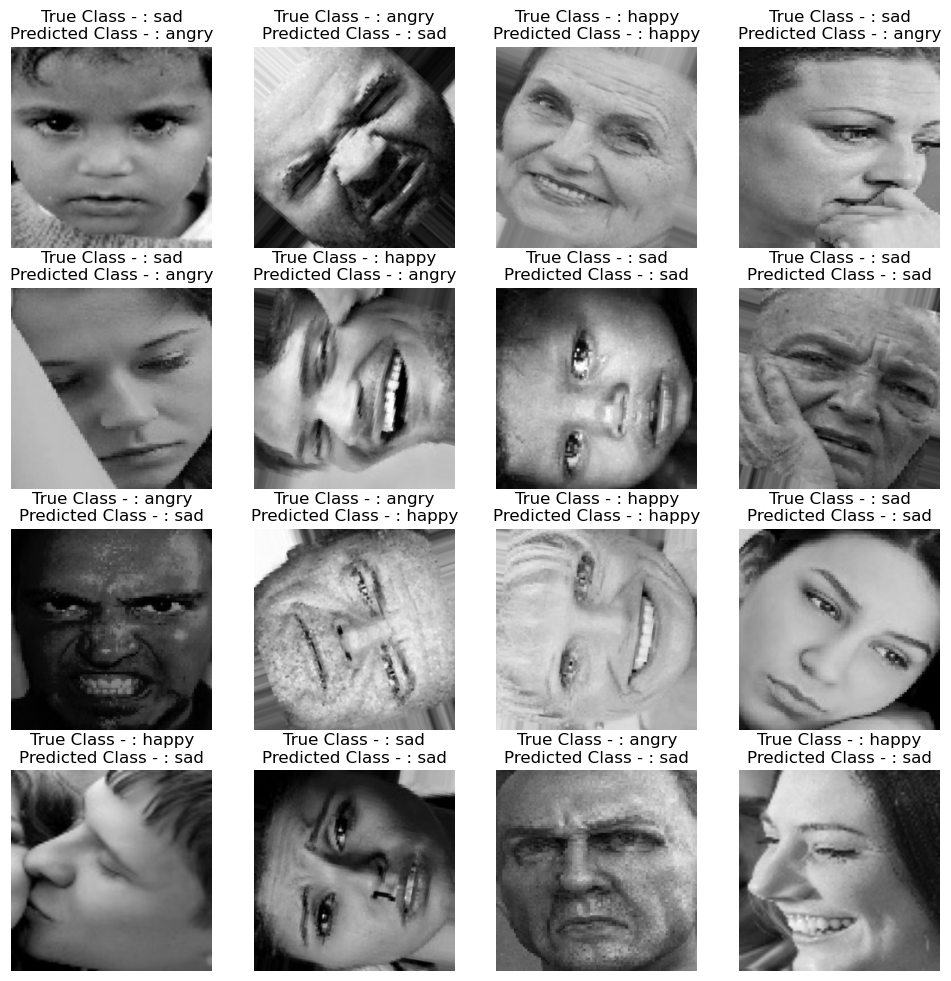

In [37]:
# Create a figure and axes for plotting
plt.figure(figsize=(12, 12))

# Iterate through the first 16 samples in the dataset
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        # Display the image
        plt.imshow(images[i]/255.)  # Display only the first image in the batch
        # Display the label
        true_class_name = class_names[labels[i].numpy()]
        predicted_class_name = class_names[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]
        plt.title("True Class - : " + true_class_name + "\nPredicted Class - : " + predicted_class_name)

        plt.axis('off')

# Confusion Matrix

In [38]:
predicteds = []
labels = []
for im, label in val_dataset:
  predicteds.append(np.argmax(lenet_model(im) , axis = 1))
  labels.append(label.numpy())

In [39]:
preds = list(chain.from_iterable(predicteds))
lbls = list(chain.from_iterable(labels))


In [40]:
preds[:5]

[2, 0, 0, 2, 2]

In [41]:
lbls[:5]

[2, 1, 0, 0, 1]

In [42]:
cm = confusion_matrix(lbls, preds)
print(cm)

[[122  80 310]
 [224 199 579]
 [149  82 514]]


Text(0.5, 58.7222222222222, 'Predicted')

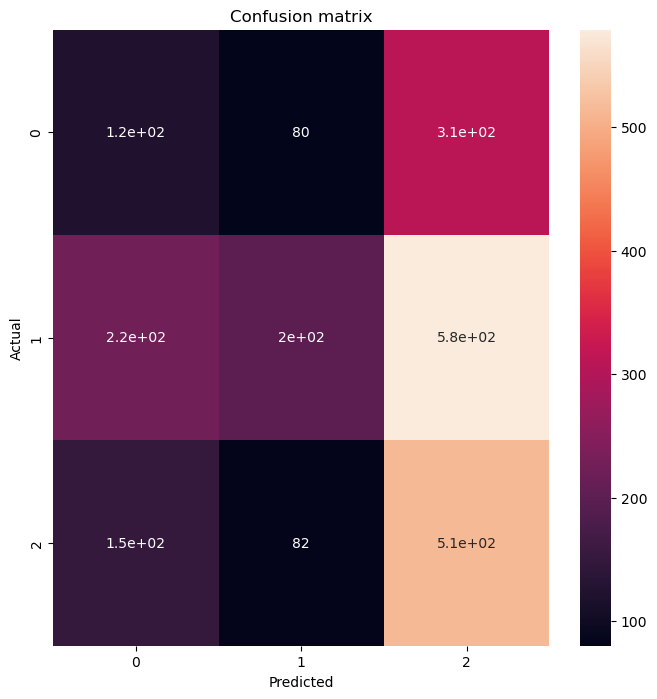

In [43]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')